# Nearest Neighbour

Source
- [Image Classification: Data-driven Approach, k-Nearest Neighbor, train/val/test splits](https://cs231n.github.io/classification/)
- [The CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html)

---

In [1]:
import pickle
from matplotlib import pyplot as plt
import numpy as np
import threading
from scipy import stats
import copy

In [3]:
#Util functions
# https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

## Data Exploration

---

In [5]:
#Global variables
d = unpickle("data/cifar-10-batches-py/data_batch_1")
names = unpickle("data/cifar-10-batches-py/batches.meta")

names.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [6]:
data = d[b'data']
labels = d[b'labels']
label_names = names[b'label_names']

label_names

[b'airplane',
 b'automobile',
 b'bird',
 b'cat',
 b'deer',
 b'dog',
 b'frog',
 b'horse',
 b'ship',
 b'truck']

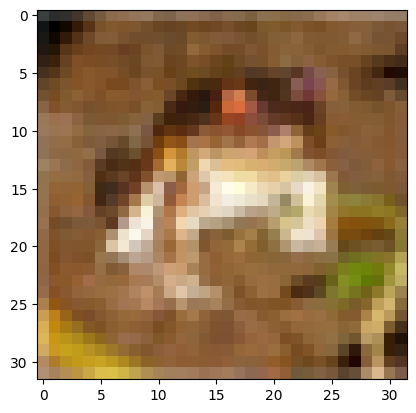

frog


In [8]:
#Visualizing
def getImage(index, data, labels):
    img = data[index]
    temp = []

    for i in range(32):
        t = []
        for j in range(32):
            t.append([img[j+(32*i)], img[(j+1024)+(32*i)], img[(j+1024*2)+(32*i)]]) # R,G,B
        temp.append(t)
    
    return temp, labels[index]

image, label = getImage(0, data, labels)
plt.imshow(image)
plt.show()
print(label_names[label].decode("utf-8"))

## Nearest Neighbour Implementation

---

In [9]:
# Nearest Neighbour
class NearestNeighbour():
    data=[]
    labels=[]

    def train(self, data, labels):
        self.data = data
        self.labels = labels

    def getLabel(self, i):
        return np.take(self.labels, i)
    
    def getData(self, i):
        return self.data[i]

    # With L1 Score
    def predict(self, img):
        min_diff = np.sum(np.abs(np.subtract(self.data,img)), axis=1)
        return min_diff.min() , min_diff.argmin()

In [13]:
#Visualising the numpy functions
s1 = [[1,3],[2,1],[3,4]] #3x2. wants it to be 3 x 1 x 2
s2 = [2,1] # 1x2

# s1 = np.reshape(s1,(3,1,2))

print(np.subtract(s1,s2))
print("---")
print(np.square(np.subtract(s1,s2)))
print("---")
print(np.sum(np.square(np.subtract(s1,s2)), axis=1))

[[-1  2]
 [ 0  0]
 [ 1  3]]
---
[[1 4]
 [0 0]
 [1 9]]
---
[ 5  0 10]


In [15]:
#Prepare dataset
batches = []
labels = []
for i in range(5):
    batch = unpickle("data/cifar-10-batches-py/data_batch_"+str(i+1))
    batches.extend(batch[b'data'])
    labels.extend(batch[b'labels'])
batches = np.array(batches)
labels = np.array(labels)
batches, labels

test_data, test_labels = [], []
batch = unpickle("data/cifar-10-batches-py/test_batch")
test_data.extend(batch[b'data'])
test_labels.extend(batch[b'labels'])

test_data = np.array(test_data)
test_labels = np.array(test_labels)

Actual: 0 airplane 
Pred: 3 cat


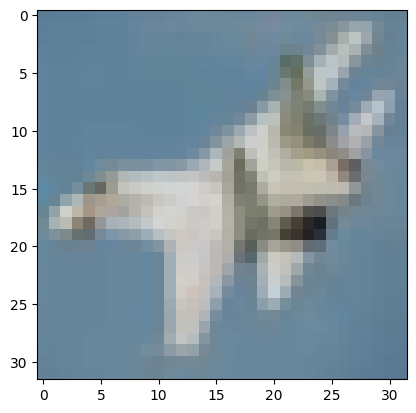

In [23]:
#Testing 
nearestNeighbour = NearestNeighbour()
nearestNeighbour.train(batches, labels)

index = 10
test = test_data[index]
label = test_labels[index]

min, i = nearestNeighbour.predict(test)

img, label = getImage(index, test_data, test_labels)

print("Actual: "+str(label), label_names[label].decode("utf-8"), "\nPred: "+ str(nearestNeighbour.getLabel(i)), label_names[nearestNeighbour.getLabel(i)].decode("utf-8"))
plt.imshow(img)

In [23]:
#Multi-threading approach because my computer's too slow
lock = threading.Lock()
counter = 0

batches = []
labels = []
for i in range(5):
    batch = unpickle("data/cifar-10-batches-py/data_batch_"+str(i+1))
    batches.extend(batch[b'data'])
    labels.extend(batch[b'labels'])
batches = np.array(batches)
labels = np.array(labels)
batches, labels

nearestNeighbour = NearestNeighbour()
nearestNeighbour.train(batches, labels)

test_data, test_labels = [], []
batch = unpickle("data/cifar-10-batches-py/test_batch")
test_data.extend(batch[b'data'])
test_labels.extend(batch[b'labels'])
test_data = np.array(test_data)
test_labels = np.array(test_labels)

indexes = [x for x in range(len(test_labels))]

runners = 10
corrects=[0 for _ in range(runners)]

#Test accuracy
def task(runner):
    global counter, indexes, lock, test_data, test_labels, nearestNeighbour, corrects

    count = 0

    while True:
        with lock:
            if(len(indexes) == 0):
                corrects[runner-1] = count
                return
            i = indexes.pop()
            counter+=1
            print("#", counter)
        
        test = test_data[i]
        label = test_labels[i]

        _, index = nearestNeighbour.predict(test)
        count += np.sum(np.equal(nearestNeighbour.getLabel(index),label))

        print("runner:",runner,"Correct so far:", count)

#Start           
threads = []
for i in range(runners):
    threads.append(threading.Thread(target=task, args=(i+1,)))

for i in range(runners):
    threads[i].start()

for i in range(runners):
    threads[i].join()

corrects, sum(corrects)

## K Nearest Neighbour

---

In [3]:
# K Nearest Neighbour
class KNearestNeighbour():
    data=[]
    labels=[]
    k=1

    def __init__(self, k =1):
        self.k = k

    def train(self, data, labels):
        self.data = data
        self.labels = labels

    def getLabel(self, i):
        return np.take(self.labels, i)
    
    def getData(self, i):
        return self.data[i]

    # With L1 Score
    def predict(self, img):
        min_diff = np.sum(np.abs(np.subtract(self.data,img)), axis=1)
        args = np.argsort(min_diff)[:self.k]

        diff = np.take(min_diff, args)
        
        y = stats.mode(np.take(self.labels, args)).mode

        return diff , y

In [9]:
#Cross Validation, multi-threaded
lock = threading.Lock()

#Test accuracy
def task(runner):
    global counter, indexes, lock, x_test, y_test, nearestNeighbour, corrects

    count = 0

    while True:
        with lock:
            if(len(indexes) == 0):
                corrects[runner-1] = count
                return
            i = indexes.pop()
            counter+=1
            print("#", counter)
        
        test = x_test[i]
        label = y_test[i]

        _, y = nearestNeighbour.predict(test)
        count += np.sum(np.equal(y,label))

        print("runner:",runner,"Correct so far:", count)

batches = []
labels = []
for i in range(5):
    batch = unpickle("data/cifar-10-batches-py/data_batch_"+str(i+1))
    batches.append(batch[b'data'])
    labels.append(batch[b'labels'])
batches = np.array(batches)
labels = np.array(labels)

accuracies = []
runners = 10
for i in range(len(batches)):
    x_test, y_test = batches[i], labels[i]
    indices = [x for x in range(len(batches)) if x!=i]
    x_train, y_train = np.take(batches, indices, axis=0), np.take(labels, indices, axis=0).flatten()
    x_train = x_train.reshape((x_train.shape[0]*x_train.shape[1],)+x_train.shape[2:])

    counter = 0
    indexes = [x for x in range(len(y_test))]
    threads = []
    corrects = [0 for _ in range(runners)]
    for i in range(runners):
        threads.append(threading.Thread(target=task, args=(i+1,)))

    nearestNeighbour = KNearestNeighbour(1) # can vary this 
    nearestNeighbour.train(x_train, y_train)

    for j in range(runners):
        threads[j].start()

    for j in range(runners):
        threads[j].join()
    
    accuracies.append(copy.deepcopy(corrects))
accuracies, np.sum(accuracies, axis=1)